In [1]:
from ctypes import *


treelib = cdll.LoadLibrary(
    "/home/clouder/Documents/GitRepos/decisiontree/build/linux/x86_64/release/libtree.so"
)

In [2]:
from dataclasses import dataclass


treelib.create_fit_options.argtypes = [c_int32, c_int32, c_int32, c_double]
treelib.create_fit_options.restype = c_void_p


def create_fit_options(
    max_depth: int,
    min_samples_leaf: int,
    min_samples_split: int,
    min_purity_decrease: float,
) -> c_void_p:
    return treelib.create_fit_options(
        max_depth, min_samples_leaf, min_samples_split, min_purity_decrease
    )


def delete_fit_options(options: c_void_p):
    treelib.delete_fit_options(options)


class TreeOptions:
    def __init__(
        self,
        max_depth: int,
        min_samples_leaf: int,
        min_samples_split: int,
        min_purity_decrease: float,
    ):
        self.options = create_fit_options(
            max_depth, min_samples_leaf, min_samples_split, min_purity_decrease
        )

    def __del__(self):
        # delete_fit_options(self.options)
        pass


treelib.create_sampleset.argtypes = []
treelib.create_sampleset.restype = c_void_p
treelib.create_sample.argtypes = [
    c_void_p,
    c_int32,
    c_uint64,
    POINTER(c_double),
    c_uint64,
    POINTER(c_int32),
]


@dataclass
class Sample:
    num_num: int
    cat_num: int
    nums: list[float]
    cats: list[int]
    label: int


class SampleSet:
    def __init__(self):
        self.sampleset = treelib.create_sampleset()

    def add_sample(self, sample: Sample):
        c_nums = c_double * len(sample.nums)
        c_cats = c_int32 * len(sample.cats)
        assert sample.num_num == len(sample.nums)
        assert sample.cat_num == len(sample.cats)
        nums = cast(pointer(c_nums(*sample.nums)), POINTER(c_double))
        cats = cast(pointer(c_cats(*sample.cats)), POINTER(c_int32))
        treelib.create_sample(
            self.sampleset,
            c_int32(sample.label),
            c_uint64(sample.num_num),
            nums,
            c_uint64(sample.cat_num),
            cats,
        )

    def __del__(self):
        # treelib.delete_sampleset(self.sampleset)
        pass


treelib.create_tree.argtypes = [c_uint64, c_uint64, c_uint64]
treelib.create_tree.restype = c_void_p
treelib.tree_fit.argtypes = [c_void_p, c_void_p, c_void_p]
treelib.tree_predict.argtypes = [c_void_p, c_void_p]
treelib.tree_predict.restype = c_int32
treelib.show_tree.argtypes = [c_void_p]


class DecisionTree:
    def __init__(self, num_feats: int, cat_feats: int, labels: int):
        self.num_feats = num_feats
        self.cat_feats = cat_feats
        self.labels = labels
        self.tree = treelib.create_tree(self.num_feats, self.cat_feats, self.labels)

    def fit(self, sampleset: SampleSet, options: TreeOptions):
        treelib.tree_fit(self.tree, sampleset.sampleset, options.options)

    def predict(self, sample: Sample) -> c_int32:
        tmp = SampleSet()
        tmp.add_sample(sample)
        res = treelib.tree_predict(self.tree, tmp.sampleset)
        del tmp
        return res

    def show(self):
        treelib.show_tree(self.tree)

    def __del__(self):
        # treelib.delete_tree(self.tree)
        pass

In [3]:
testset = treelib.create_sampleset()
treelib.create_sample(testset, 1, 1, pointer(c_double(0.3)), 1, pointer(c_int32(0)))

0

In [4]:
def my_sample(x1: float, x2: float, x3: int, label: int):
    return Sample(num_num=2, cat_num=1, nums=[x1, x2], cats=[x3], label=label)


options = TreeOptions(6, 2, 2, -1)
train_samples = SampleSet()
# train_samples.add_sample(my_sample(0.3, 0.7, 0, 1))
actuals = []
for a in range(10):
    for b in range(10):
        for c in range(2):
            label = int(a * (b + 1) / 10 + c * 1 > 2.5)
            now = my_sample(a * 0.3, b * 0.7, c, label)
            actuals.append(now)
            train_samples.add_sample(now)

In [5]:
tree = DecisionTree(2, 1, 2)

tree.fit(train_samples, options.options)

AttributeError: 'int' object has no attribute 'options'

In [9]:
for sample in actuals:
    print("origin", int(sample.label), "predict:", tree.predict(sample))

In [10]:
tree.show()

In [3]:
import polars as pl

data = (
    pl.read_csv("adult.data", has_header=False, null_values="NA")
    .drop_nulls()
    .with_columns(
        y=pl.when(pl.col("column_15").str.contains(">"))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
    )
    .drop("column_15")
    .with_columns(age=pl.col("column_1"))
    .drop("column_1")
)
data

column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,y,age
str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i64
""" State-gov""",""" 77516""",""" Bachelors""",""" 13""",""" Never-married""",""" Adm-clerical""",""" Not-in-family""",""" White""",""" Male""",""" 2174""",""" 0""",""" 40""",""" United-States""",0,39
""" Self-emp-not-inc""",""" 83311""",""" Bachelors""",""" 13""",""" Married-civ-spouse""",""" Exec-managerial""",""" Husband""",""" White""",""" Male""",""" 0""",""" 0""",""" 13""",""" United-States""",0,50
""" Private""",""" 215646""",""" HS-grad""",""" 9""",""" Divorced""",""" Handlers-cleaners""",""" Not-in-family""",""" White""",""" Male""",""" 0""",""" 0""",""" 40""",""" United-States""",0,38
""" Private""",""" 234721""",""" 11th""",""" 7""",""" Married-civ-spouse""",""" Handlers-cleaners""",""" Husband""",""" Black""",""" Male""",""" 0""",""" 0""",""" 40""",""" United-States""",0,53
""" Private""",""" 338409""",""" Bachelors""",""" 13""",""" Married-civ-spouse""",""" Prof-specialty""",""" Wife""",""" Black""",""" Female""",""" 0""",""" 0""",""" 40""",""" Cuba""",0,28
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
""" Private""",""" 257302""",""" Assoc-acdm""",""" 12""",""" Married-civ-spouse""",""" Tech-support""",""" Wife""",""" White""",""" Female""",""" 0""",""" 0""",""" 38""",""" United-States""",0,27
""" Private""",""" 154374""",""" HS-grad""",""" 9""",""" Married-civ-spouse""",""" Machine-op-inspct""",""" Husband""",""" White""",""" Male""",""" 0""",""" 0""",""" 40""",""" United-States""",1,40
""" Private""",""" 151910""",""" HS-grad""",""" 9""",""" Widowed""",""" Adm-clerical""",""" Unmarried""",""" White""",""" Female""",""" 0""",""" 0""",""" 40""",""" United-States""",0,58


In [4]:
display(data["y"].value_counts())
print(data.columns)
min_acc = data["y"].value_counts()["count"].max() / len(data)
print("min acc:", min_acc)
display(data["column_3"].value_counts())

y,count
i32,u32
1,7841
0,24720


['column_2', 'column_3', 'column_4', 'column_5', 'column_6', 'column_7', 'column_8', 'column_9', 'column_10', 'column_11', 'column_12', 'column_13', 'column_14', 'y', 'age']
min acc: 0.7591904425539756


column_3,count
str,u32
""" 404599""",1
""" 301514""",1
""" 85815""",2
""" 84954""",1
""" 289147""",2
…,…
""" 284129""",2
""" 491000""",2
""" 86143""",5


In [5]:
# convert all strings to numbers and cates

cate_cols = []
num_cols = []
res = data.lazy()
for col in data.columns:
    if data[col].dtype != pl.Utf8:
        continue
    if isinstance(data[col][0], str) and str(data[col][0]).strip().isnumeric():
        now_name = f"num{len(num_cols)}"
        num_cols.append(now_name)
        res = res.with_columns(
            pl.col(col).str.strip_chars(" ").cast(pl.Int64).alias(now_name)
        ).drop(col)
    else:
        now_name = f"category{len(cate_cols)}"
        print(len(cate_cols), col)
        cate_cols.append(now_name)
        res = res.with_columns(
            pl.col(col).cast(pl.Categorical).to_physical().alias(now_name)
        ).drop(col)
res = res.collect()
display(res)
print("cate", cate_cols, "num", num_cols)
data = res

0 column_2
1 column_4
2 column_6
3 column_7
4 column_8
5 column_9
6 column_10
7 column_14


y,age,category0,num0,category1,num1,category2,category3,category4,category5,category6,num2,num3,num4,category7
i32,i64,u32,i64,u32,i64,u32,u32,u32,u32,u32,i64,i64,i64,u32
0,39,0,77516,0,13,0,0,0,0,0,2174,0,40,0
0,50,1,83311,0,13,1,1,1,0,0,0,0,13,0
0,38,2,215646,1,9,2,2,0,0,0,0,0,40,0
0,53,2,234721,2,7,1,2,1,1,0,0,0,40,0
0,28,2,338409,0,13,1,3,2,1,1,0,0,40,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,27,0,257302,7,12,3,12,4,0,0,0,0,38,0
1,40,0,154374,0,9,3,5,2,0,1,0,0,40,0
0,58,0,151910,0,9,4,0,0,0,0,0,0,40,0


cate ['category0', 'category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7'] num ['num0', 'num1', 'num2', 'num3', 'num4']


In [54]:
from sklearn import feature_selection

cols = data.columns
print(len(cols))

res = pl.DataFrame(
    {
        "mutual": feature_selection.mutual_info_classif(data.drop("y"), data["y"]),
        "name": [x for x in cols if x != "y"],
    }
).sort("mutual", descending=True)
res

15


mutual,name
f64,str
0.080768,"""num2"""
0.068383,"""age"""
0.064701,"""num1"""
0.040812,"""num4"""
0.03722,"""num3"""
…,…
0.005116,"""category1"""
0.004061,"""category5"""
0.002782,"""category6"""


NUM feat 2 < threshold 5060
 NUM feat 1 < threshold 12
  NUM feat 4 < threshold 37
   NUM feat 3 < threshold 1876
    NUM feat 1 < threshold 10
     NUM feat 4 < threshold 34
      NUM feat 1 < threshold 8
       NUM feat 4 < threshold 29
        CAT feat 7 cate = 6
         NUM feat 0 < threshold 72931
          LEAF label 1
          LEAF label 0
         CAT feat 2 cate = 2
          NUM feat 0 < threshold 36209
           NUM feat 0 < threshold 33404
            LEAF label 0
            LEAF label 1
           NUM feat 0 < threshold 387568
            LEAF label 0
            NUM feat 0 < threshold 388625
             LEAF label 1
             LEAF label 0
          LEAF label 0
        NUM feat 0 < threshold 196773
         NUM feat 0 < threshold 26248
          LEAF label 1
          NUM feat 0 < threshold 196736
           CAT feat 7 cate = 14
            LEAF label 1
            CAT feat 1 cate = 2
             CAT feat 3 cate = 3
              LEAF label 1
              CAT fe

fbeta,acc,balanced_acc
f64,f64,f64
0.553801,0.81345,0.697299




               precision    recall  f1-score   support

           0       0.85      0.94      0.89      4898
           1       0.73      0.50      0.59      1615

    accuracy                           0.83      6513
   macro avg       0.79      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



fbeta,acc,balanced_acc
f64,f64,f64
0.589838,0.828957,0.717363


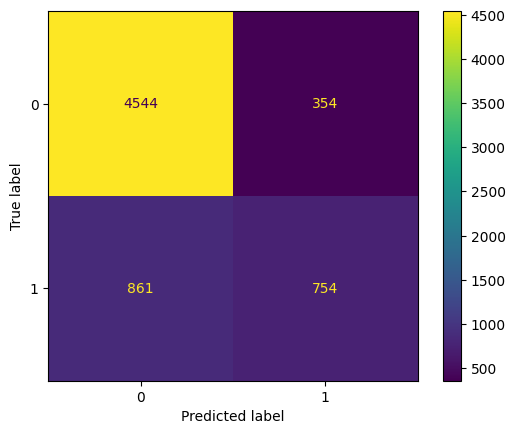

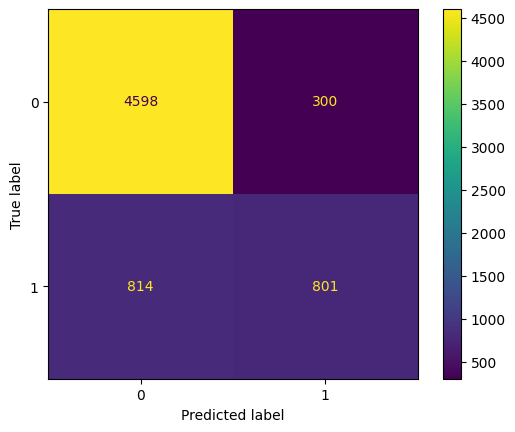

In [77]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    fbeta_score,
)

seed = 1145141919
trainset, testset = train_test_split(data, test_size=0.2, random_state=seed)
num_cols.sort()
cate_cols.sort()


def to_sampleset(data: pl.DataFrame):
    sampleset = SampleSet()
    # d1 = data.filter(pl.col("y") == 1)
    # d0 = data.filter(pl.col("y") == 0)
    # minl = min(len(d1), len(d0))
    # d = pl.concat([d1.head(minl), (d0.head(minl))])
    d = data
    # add samples
    for x in d.iter_rows(named=True):
        cats = []
        nums = []
        for col in cate_cols:
            cats.append(x[col])
        for col in num_cols:
            nums.append(x[col])
        sampleset.add_sample(
            Sample(
                num_num=len(nums), cat_num=len(cats), nums=nums, cats=cats, label=x["y"]
            )
        )
    return sampleset


def append_predict(data: pl.DataFrame, tree: DecisionTree):
    # add samples
    predys = []
    for x in data.iter_rows(named=True):
        cats = []
        nums = []
        for col in cate_cols:
            cats.append(x[col])
        for col in num_cols:
            nums.append(x[col])
        yhat = tree.predict(
            Sample(
                num_num=len(nums), cat_num=len(cats), nums=nums, cats=cats, label=x["y"]
            )
        )
        predys.append(yhat)
    return data.with_columns(pl.Series("yhat", predys))


tree = DecisionTree(len(num_cols), len(cate_cols), 2)
options = TreeOptions(
    max_depth=16, min_samples_leaf=1, min_samples_split=3, min_purity_decrease=1e-5
)
train_samples = to_sampleset(trainset)
tree.fit(train_samples, options)
tree.show()

res_df = append_predict(testset, tree)

from sklearn.tree import DecisionTreeClassifier, plot_tree

# sktree = DecisionTreeClassifier(criterion="log_loss",min_samples_leaf=1,max_depth=16,min_samples_split=3,min_impurity_decrease=1e-5)
sktree = RandomForestClassifier()
sktree.fit(trainset[cate_cols + num_cols], trainset["y"])
base = testset.with_columns(yhat=sktree.predict(testset[cate_cols + num_cols]))


def validate(res_df: pl.DataFrame):
    acc = accuracy_score(res_df["y"], res_df["yhat"])
    balanced_acc = balanced_accuracy_score(res_df["y"], res_df["yhat"])
    fbeta = fbeta_score(res_df["y"], res_df["yhat"], beta=1)
    ConfusionMatrixDisplay.from_predictions(res_df["y"], res_df["yhat"])
    print("\n\n", classification_report(res_df["y"], res_df["yhat"]))
    return pl.DataFrame({"fbeta": fbeta, "acc": acc, "balanced_acc": balanced_acc})


# tree.show()
display(validate(res_df))
display(validate(base))
# visualize sktree
# ai write for me
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# plot_tree(sktree,proportion=True)
# plt.show()

In [8]:
"""Hyper parameter tuning"""

from sklearn.metrics import fbeta_score
from sklearn.model_selection import ShuffleSplit

# use fbeta score as our metric

amax_depths = [6, 8, 10, 12, 16]
amin_samples_leafs = [1, 2, 4]
amin_purity = [1e-3, 1e-2, 1e-1]


def evaluate(data: pl.DataFrame, tree: DecisionTree, options: TreeOptions, times=100):
    ShuffleSplit